## Running my first notebook

<p>I'll be using this notebook to train a model that can recognize dog and cat photos. To do this, a dataset comprising dog and cat photos will be downloaded, and that will be used to train a model.</p>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

## Pet Classification

<p>The first few lines below serve to:

* Import all of the fastai.vision library. It gives us all the functions and classes needed to create a variety of computer vision models.
* Download a standard dataset from the fast.ai datasets collection (if not previously downloaded) to the server, extract it (if not previously extracted), and return a `Path` object with the extracted location.

In [2]:
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
path = untar_data(URLs.PETS)/'images'

<p> The <i>is_cat</i> function labels cats based on the filename rule provided by the dataset's creators. In other words, the filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise.

* For fastai to know what kind of dataset we have and how it is structured, we use `ImageDataLoaders`. Secondly, we need to intruct fastai how to get the labels from the dataset. That is achieved using the <i>is_cat</i> function defined below.
* And then a Transform function is applied, `item_tfms`, which resizes each item to a 224-pixel square.
* The most important parameter is `valid_pct`, which specifies that 20% of the data would comprise the validation set.
* The parameter `seed` sets the random seed to the same value every time we run the code. This means we get the same validation set every time we run it.</p>

In [3]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

<p>Now our image recognizer <i>(dls)</i> tells fastai to create a convolutional neural network (CNN) and specifies what artchitecture to use, what data we want to train it on, and what metric to use.

* <i>ResNets</i> are a standard piece of architecture used while implementing CNNs.
* The `34` in `resnet34` refers to the number of layers in this variant of the architecture.
* The metric, a function that measures the quality of the model's predictions using the validation set, was set to `error_rate`, which tells you what percentage of images in the validation set are being classified incorrectly.
* Since we've started with a pretrained model, the `fine_tune` method was used. The "1" in the brackets refers to the number of epochs, i.e., a complete pass through the dataset.</p>

In [4]:
import warnings
warnings.filterwarnings('ignore')
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.182616,0.015450,0.005413,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.058211,0.010924,0.003383,00:53


In [5]:
#uploader = widgets.FileUpload()
#uploader

In [6]:
# Assuming we can't click the upload button
uploader = SimpleNamespace(data = ['../images/chapter1_cat_example.jpg'])

In [7]:
img = PILImage.create(uploader.data[0])
is_cat, _, probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 0.999987


## Running a Segmentation Model

<p>Creating a model that can recognize the content of every individual pixel in an image is called segmentation.</p>

In [8]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str))

In [9]:
import warnings
warnings.filterwarnings('ignore')
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.756083,2.000573,00:03


epoch,train_loss,valid_loss,time
0,1.774525,1.552120,00:03
1,1.552608,1.281787,00:03
2,1.438856,1.138980,00:03
3,1.291609,0.972394,00:03
4,1.158033,0.860395,00:03
5,1.042086,0.802568,00:03
6,0.946872,0.787973,00:03
7,0.870920,0.784788,00:03


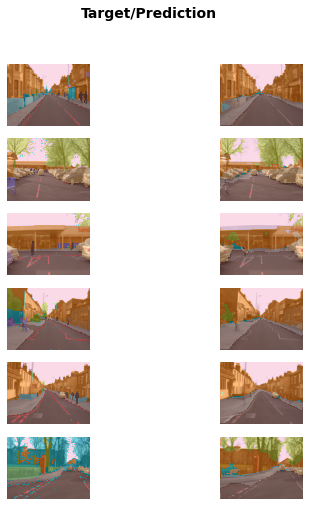

In [10]:
learn.show_results(max_n=6, figsize=(7,8))

In [ ]:
learn.predict("I really liked that movie!")

## Predicting whether a person is a high-income earner

<p>We would need to tell fastai which columns are categorical (containing values that are one of a discrete set of choices, such as occupation) versus continuous (containing a number that represents a quantity, such as age).</p>

In [16]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [17]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.418890,0.400595,0.823403,00:09
1,0.377677,0.369074,0.831542,00:09
2,0.359877,0.366028,0.831542,00:10


## Predicting movies a user might like

<p>Training a model that will predict movies people might like based on their previous viewing habots, using the MovieLens dataset. The model is predicting movie ratings on a scale of 0.5 to 5.0 to within around 0.6 average error.</p>

In [18]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.519000,1.357583,00:01


epoch,train_loss,valid_loss,time
0,1.374569,1.299210,00:01
1,1.267694,1.120391,00:01
2,1.009157,0.829508,00:01
3,0.806741,0.707759,00:01
4,0.703528,0.679191,00:01
5,0.656859,0.670780,00:01
6,0.644009,0.666150,00:01
7,0.620675,0.664232,00:01
8,0.618562,0.663095,00:01
9,0.618373,0.663131,00:01


In [19]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,8.0,58.0,5.0,4.245037
1,14.0,57.0,4.0,3.942186
2,38.0,90.0,4.5,4.215070
3,2.0,69.0,4.5,4.139312
4,71.0,99.0,3.0,4.154532
5,9.0,34.0,3.5,3.336601
6,94.0,14.0,3.5,4.356930
7,53.0,41.0,5.0,4.538529
8,90.0,35.0,4.0,4.187025
